In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Code specific to Google Colab
    print("Running in Google Colab")

    # Additional setup commands for Colab
    !pip install neuralforecast
    !pip install gymnasium
else:
    # Code for other environments (e.g., VS Code)
    print("Running in another environment (e.g., VS Code)")

Running in Google Colab
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-ma

In [2]:
if IN_COLAB:
    # Retrive required files
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/environments/stockenv.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/cleandata.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/data.py
    # Move all directories and files from content/raw.githubusercontent.com to content/
    !mv /content/raw.githubusercontent.com/* /content/

    # Delete the raw.githubusercontent.com directory
    !rm -rf /content/raw.githubusercontent.com

--2024-05-05 09:14:26--  https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/environments/stockenv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /CodeBeckZero/MADDQN/main/environments/stockenv.py [following]
--2024-05-05 09:14:26--  https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/environments/stockenv.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 12351 (12K) [text/plain]
Saving to: ‘/content/raw.githubusercontent.com/environments/stockenv.py’

raw.githubuserconte 100%[===================>]  12.06K  --.-KB/s    in 0s      

2024-05-05 09:14:27 (58.4 MB/s) - ‘/content/raw.githubusercontent.com/environments/stockenv.py’ saved [12351/12351]

FINISHE

In [3]:
import sys
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utilities.cleandata as cln
from utilities.data import RunningWindowDataset, DateTimeSlidingWindowDataset
from environments.stockenv import ContinuousOHLCVEnv
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
from neuralforecast.losses.numpy import mae, mse
from datetime import datetime

def set_seed(seed):
    """Set seed for reproducibility."""
    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)

    # If you are using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        # Additional settings to force determinism in your operations:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
RANDOM_SEED = 42
set_seed(RANDOM_SEED)

pwd = "C:/programming/MADDQN"
sys.path.append(pwd)

# Input Data Location, File Name, Stock name for labels
input_url = 'https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/input_data'

stock_inputs ={'DJI':'^DJI_daily.csv',
               'NDAQ': '^IXIC_daily.csv',
               'SP500': '^SPX_daily.csv',
               'AAPL': 'AAPL_daily.csv',
               'AMZN': 'AMZN_daily.csv',
               'GOOGL': 'GOOGL_daily.csv',
               'MSFT': 'MSFT_daily.csv',
               'SINE': 'sine_wave_daily.csv',
               'FORD': 'F_daily.csv',
               'JNJ': 'JNJ_daily.csv',
               'NEE': 'NEE_daily.csv',
               'PFE': 'PFE_daily.csv',
               'TSLA': 'TSLA_daily.csv'}


# Exodenus Variable Input
exo_var_datasets = ['DJI','NDAQ','SP500']
exo_vars = ['close']

exo_vars_df = pd.DataFrame()
for name, file in stock_inputs.items():
    if name in exo_var_datasets:
        df_ohlcv = cln.YAHOO_csv_input(file, input_url)
        if exo_var_datasets.index(name) == 0:
            exo_vars_df['date'] = df_ohlcv['date']
            for column in exo_vars:
                exo_vars_df[f'{name}_{column}'] = df_ohlcv[column]
        else:
            df_merge = df_ohlcv[['date'] + exo_vars]  # Selecting 'date' and desired columns
            exo_vars_df = pd.merge(exo_vars_df, df_merge, on='date', how='inner')
            for column in exo_vars:
                exo_vars_df.rename(columns={column:f'{name}_{column}'},inplace=True)

exo_vars_df.rename(columns={'date':'ds'},inplace=True)

# Training Inputs
trn_keys = ['DJI','NDAQ','SP500']
training_range = ('2007-01-03','2020-12-31')
trn_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in training_range]

# Validation Inputs
val_keys = trn_keys
validation_range = ('2021-01-04','2021-12-31')
val_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in validation_range]

# Testing Inputs
tst_keys = ['AAPL','AMZN']#,'GOOGL','MSFT','SINE','FORD','JNJ','NEE', 'PFE','TSLA']
testing_range = ('2007-01-03','2023-12-28')
tst_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in testing_range]

window_size = 28 # Window size
n_prediction = 5 # Number points to predict in the future
columns = ['open','high','low','close','volume']

env = {}

for name, file in stock_inputs.items():
    if name in set(trn_keys + val_keys + tst_keys):
        # Import
        df = cln.YAHOO_csv_input(file, input_url)
        # Standardize Data
        norm_start_idx = df[df['date'] == trn_dt_range[0]].index.tolist()[0]
        norm_finish_idx = df[df['date'] == trn_dt_range[1]].index.tolist()[0]
        norm_df = cln.normalize_df_ohlcv_by_row_range(df,norm_start_idx,
                                                              norm_finish_idx)

        # Gen Input DF required for NeuralCast TimesNet
        timesnet_df = cln.gen_long_form_timesnet_from_ohlcv(norm_df)


        rw_datatime = DateTimeSlidingWindowDataset(df['date'],window_size)
        rw_raw_data = RunningWindowDataset(norm_df[columns],window_size)
        rw_std_data = RunningWindowDataset(norm_df[columns],window_size)
        rw_closing_price = RunningWindowDataset(df[['close']],window_size)
        data_dic = {'raw_data': rw_raw_data, 'price':rw_closing_price,
                'std_data':rw_raw_data, 'date':rw_datatime,
                'long_df': timesnet_df}
        env[name] = data_dic





In [5]:
trn_env = {}
tst_env = {}

for name in trn_keys:
    data = env[name]['long_df'][env[name]['long_df']['unique_id'] == 'close']
    data_idx = data[(data['ds'] >= trn_dt_range[0]) & (data['ds'] <= trn_dt_range[1])]
    trn_env[name] = data_idx

for name in tst_keys:
    data = env[name]['long_df'][env[name]['long_df']['unique_id'] == 'close']
    data_idx = data[(data['ds'] >= tst_dt_range[0]) & (data['ds'] <= tst_dt_range[1])]
    tst_env[name] = data_idx


In [ ]:
"""# Original code before setting the column order
df_timesnet = df_ohlcv.copy()
df_timesnet['unique_id'] = 'close'
df_timesnet.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)
df_timesnet.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
merged_df_timesnet = pd.merge(df_timesnet, exo_vars_df, on='ds', how='inner')
# Set the column order
first_three_columns = ['ds', 'unique_id', 'y']
remaining_columns = [x for x in merged_df_timesnet.columns if x not in first_three_columns]
new_column_order = first_three_columns + remaining_columns
merged_df_timesnet = merged_df_timesnet[new_column_order]
# Display the DataFrame
display(merged_df_timesnet.sample(20))"""

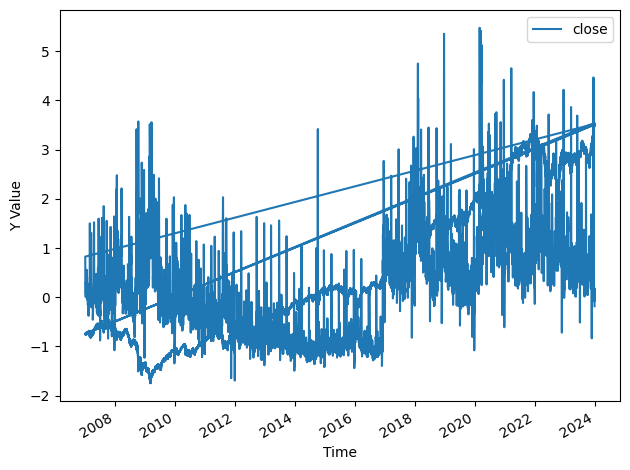

In [6]:
fig, ax = plt.subplots()

ax.plot(env['DJI']['long_df']['ds'], env['DJI']['long_df']['y'], label='close')

ax.set_xlabel('Time')
ax.set_ylabel('Y Value')

# Add legend to distinguish between different values
ax.legend()

# Rotate and align x-axis labels
fig.autofmt_xdate()

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
timesnet_config= {
    "input_size": window_size,      # Length of input window
    "hidden_size": 256,     # Size of embedding for embedding and encoders,
    "encoder_layers": 3,                    # num of encoders
    "learning_rate": 0.0002,            # Initial Learning rate
    "batch_size": 1,                                          # Number of series in batch
    'dropout': 0.1,                                           # Dropout for embeddings
    'conv_hidden_size' : 5,                                   # Channels for the inception block
    'top_k' : 5,                                              # Top num of periods from FFT considered
    'num_kernels' : 13,                 # Number of Filters
    'max_steps' : 100,                 # Number of Training Steps
    'early_stop_patience_steps' : 10,  # early stoppage on validation
    'val_check_steps' : 5,             # Val check every X steps,
    'windows_batch_size' : 60,         # Number of windows in training epoch
    'valid_batch_size' : 60
}


model = TimesNet(h = n_prediction, # Forecast horizon
                 input_size = window_size, # Length of Batches
                 batch_size = 1, # Number of timeseries to predict
                 #futr_exog_list = remaining_columns,
                 hidden_size = 128, # Size of embedding for embedding and encoders,
                 dropout = 0.25, # Dropout for embeddings
                 conv_hidden_size = 3, # Channels for the inception block
                 top_k = 5, # Top num of periods from FFT considered
                 num_kernels = 13, # number of kernels for the inception block
                 encoder_layers = 3, # num of encoders
                 max_steps = 500, # of training steps
                 early_stop_patience_steps = -1, #early stoppage on validation
                 val_check_steps = 5, # Val check every X steps,
                 windows_batch_size = 128, # Number of windows in training epoch,
                 learning_rate = 0.0008,
                 random_seed = RANDOM_SEED)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 42


In [7]:
nf = NeuralForecast(models=[model], freq='d')

for key in trn_keys:
  nf.fit(df=trn_env[key])

nf.save(path='./checkpoints/test_run/',
        model_index=None,
        overwrite=True,
        save_dataset=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 6.7 M 
4 | enc_embedding  | DataEmbedding | 384   
5 | layer_norm     | LayerNorm     | 256   
6 | predict_linear | Linear        | 957   
7 | projection     | Linear        | 129   
--------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 6.7 M 
4 | enc_embedding  | DataEmbedding | 384   
5 | layer_norm     | LayerNorm     | 256   
6 | predict_linear | Linear        | 957   
7 | projection     | Linear        | 129   
--------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [1]:
test_results = {}

for key in tst_keys:
  results = nf.predict(df=tst_env[key])
  test_results[key] = results

test = nf.predict(df=tst_env[key].iloc[3900:3920])
print(test,tst_env[key].iloc[3920:3925])


NameError: name 'tst_keys' is not defined

ds  TimesNet
unique_id                     
close     2022-12-31  4.192368
close     2023-01-01  4.212639
close     2023-01-02  4.093163
close     2023-01-03  4.036833
close     2023-01-04  4.044442

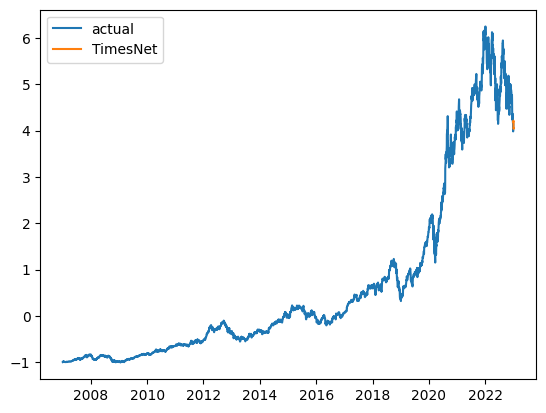

<Figure size 640x480 with 0 Axes>

In [14]:
display(test_results['AAPL'])

fig, ax = plt.subplots()

ax.plot(tst_env['AAPL']['ds'], tst_env['AAPL']['y'], label='actual')
ax.plot(test_results['AAPL']['ds'], test_results['AAPL']['TimesNet'], label='TimesNet')


ax.legend(loc='best')
# Set the x-axis limit
#plt.xlim(tst_dt_range[0], tst_dt_range[1])  # Adjust the limits as needed

# Show the plot
plt.show()

fig.autofmt_xdate()
plt.tight_layout()